In [1]:
from tqdm import tqdm
import gc
import pickle
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import levene, f_oneway
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ks_2samp

In [2]:
train_df = pl.read_parquet(
    "data/raw/train.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [3]:
test_df = pl.read_parquet(
    "data/raw/test.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [4]:
print(train_df.columns)

['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X13

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2632/293337480.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(train_df.columns)


Text(0.5, 1.0, 'Label Distribution')

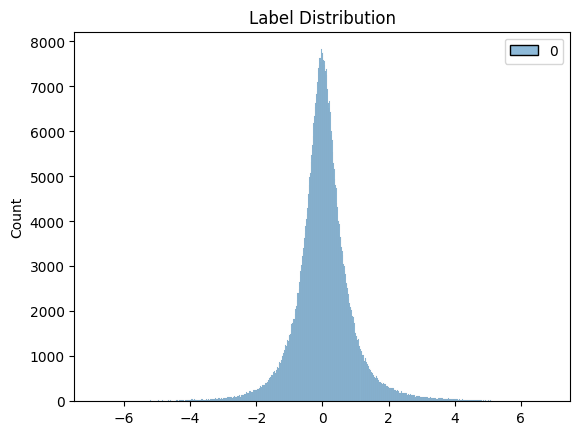

In [5]:
sns.histplot(train_df.select("label").collect().to_numpy())
plt.xlim([-7.5, 7.5])
plt.title("Label Distribution")

In [6]:
print(train_df.select("label").quantile(0.25, "nearest").collect().item(), train_df.select("label").quantile(0.75, "nearest").collect().item())

-0.3815867679423254 0.4341385161847758


In [7]:
train_df.select("__index_level_0__").collect()

__index_level_0__
datetime[ns]
2023-03-01 00:00:00
2023-03-01 00:01:00
2023-03-01 00:02:00
2023-03-01 00:03:00
2023-03-01 00:04:00
…
2024-02-29 23:55:00
2024-02-29 23:56:00
2024-02-29 23:57:00


In [8]:
# drop timestamp since test data does not have timestamp
train_df = train_df.drop("__index_level_0__")

In [9]:
# Check for nas in train or test
temp = train_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col

[]

In [10]:
temp = test_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col
# no nas issue in train and test

[]

In [11]:
# check all possible datatypes
print(set(train_df.dtypes))

{Float64}


/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2632/1737341288.py:2: PerformanceWarning: Determining the data types of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().dtypes()` to get the data types without this warning.
  print(set(train_df.dtypes))


In [12]:
# check for possible constant columns
constant_columns = []
for col in train_df.columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        constant_columns.append(col)
print(constant_columns)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2632/2295361549.py:3: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col in train_df.columns:


[]


In [13]:
# check if same issue might also appear in test
actual_constant_columns = []
for col in constant_columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        actual_constant_columns.append(col)
print(set(constant_columns) - set(actual_constant_columns)) # all are constant => can remove?

set()


In [14]:
train_df = train_df.drop(actual_constant_columns)

In [15]:
# # get columns pair that is perfectly (or very highly) correlated
# correlated_pair = []
# col_names = train_df.collect_schema().names()
# for i in tqdm(range(len(col_names) - 1)):
#     col1 = col_names[i]
#     if col1 not in constant_columns:
#         for j in range(i + 1, len(col_names)):
#             col2 = col_names[j]
#             if col2 not in constant_columns:
#                 x = train_df.select(col1).collect()[col1].to_numpy()
#                 y = train_df.select(col2).collect()[col2].to_numpy()
#                 if np.corrcoef(x, y)[0][1] == 1:
#                     correlated_pair.append(f"{col1}-{col2}")
# print(correlated_pair)
# print(len(correlated_pair))

In [16]:
correlated_pair = ['X62-X104', 'X62-X146', 'X68-X110', 'X68-X152', 'X74-X116', 'X74-X158', 'X80-X122', 'X80-X164', 'X86-X128', 'X86-X170', 'X92-X134', 'X92-X176', 'X98-X140', 'X98-X182', 'X104-X146', 'X110-X152', 'X116-X158', 'X122-X164', 'X128-X170', 'X134-X176', 'X140-X182', 'X309-X351', 'X309-X393', 'X315-X357', 'X315-X399', 'X327-X369', 'X327-X411', 'X333-X375', 'X333-X417', 'X339-X381', 'X339-X423', 'X345-X387', 'X345-X429', 'X351-X393', 'X357-X399', 'X369-X411', 'X375-X417', 'X381-X423', 'X387-X429']
actual_correlated_pair = []
for cp in correlated_pair:
    col1, col2 = cp.split("-")
    x = test_df.select(col1).collect()[col1].to_numpy()
    y = test_df.select(col2).collect()[col2].to_numpy()
    if np.corrcoef(x, y)[0][1] == 1:
        actual_correlated_pair.append(f"{col1}-{col2}")
set(correlated_pair) - set(actual_correlated_pair)

{'X104-X146',
 'X116-X158',
 'X309-X351',
 'X309-X393',
 'X315-X357',
 'X315-X399',
 'X351-X393',
 'X357-X399',
 'X62-X104',
 'X62-X146',
 'X74-X116',
 'X74-X158'}

In [17]:
# Group into correlated group
correlated_group = []
for cp in actual_correlated_pair:
    cp_lst = cp.split("-")
    added = False
    for inx, cg in enumerate(correlated_group):
        for var in cp_lst:
            if var in cg:
                correlated_group[inx].extend(cp_lst)
                correlated_group[inx] = list(set(correlated_group[inx]))
                added = True
                break
        if added:
            break
    if not added:
        correlated_group.append(cp_lst)
correlated_group
# 8 groups of perfectly correlated features, try to check if same things happen in test

[['X152', 'X110', 'X68'],
 ['X164', 'X80', 'X122'],
 ['X128', 'X86', 'X170'],
 ['X176', 'X134', 'X92'],
 ['X182', 'X98', 'X140'],
 ['X369', 'X411', 'X327'],
 ['X375', 'X333', 'X417'],
 ['X339', 'X423', 'X381'],
 ['X429', 'X345', 'X387']]

In [18]:
removed_col = []
for cg in correlated_group:
    removed_col.extend(cg[1:])
train_df = train_df.drop(removed_col)

In [ ]:
# Incremental PCA
inc_PCA = IncrementalPCA(n_components = 50)

# fitting a batch every turn
n_rows = train_df.select("bid_qty").count().collect()[0, 0]
batch_size = 10000
for i in tqdm(range(0, n_rows, batch_size)):
    length = min(n_rows - i, batch_size)
    train_df_batch = train_df.drop("label").slice(offset = i, length = length).collect()
    inc_PCA.partial_fit(train_df_batch)

In [ ]:
sns.barplot(inc_PCA.explained_variance_ratio_)

In [ ]:
pc1_component = pd.DataFrame(
    {
        "var": inc_PCA.feature_names_in_,
        "pc1_contribution": inc_PCA.components_[0]
    }
)

pc1_component = pc1_component.sort_values("pc1_contribution", ascending=False, key = lambda x: abs(x)).reset_index().drop("index", axis = 1)
pc1_component

In [ ]:
# Use the top 50 features
print(pc1_component.iloc[:50, ]["var"].tolist())

In [ ]:
# Also need to check correlation with target variable
var_label_correlation = []
for i in tqdm(range(pc1_component.shape[0])):
    var = pc1_component.loc[i, "var"]
    var_label_correlation.append(train_df.select(pl.corr(var, "label")).collect().item())
pc1_component["var_label_correlation"] = var_label_correlation
pc1_component

In [ ]:
pc1_component.sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

In [ ]:
pc1_component["pc1_contribution_rnk"] = pc1_component["pc1_contribution"].abs().rank(method = "min", ascending=False)
pc1_component["var_label_correlation_rnk"] = pc1_component["var_label_correlation"].abs().rank(method = "min", ascending=False)
pc1_component["average_rnk"] = (pc1_component["pc1_contribution_rnk"] + pc1_component["var_label_correlation_rnk"]) / 2
pc1_component

In [ ]:
popular_var = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]
pc1_component[pc1_component["var"].isin(popular_var)]

In [ ]:
pc1_component = pc1_component.sort_values("average_rnk").reset_index().drop("index", axis = 1)
pc1_component

In [ ]:
best_pc1_contribution = pc1_component[pc1_component["pc1_contribution_rnk"] <= 100]["var"].tolist()
with open("features/best_pc1_contribution.pkl", "wb") as f:
    pickle.dump(best_pc1_contribution, f)

In [ ]:
best_label_correlation = pc1_component[pc1_component["var_label_correlation_rnk"] <= 100]["var"].tolist()
with open("features/best_label_correlation.pkl", "wb") as f:
    pickle.dump(best_label_correlation, f)

In [ ]:
best_label_correlation_200 = pc1_component[pc1_component["var_label_correlation_rnk"] <= 200]["var"].tolist()
with open("features/best_label_correlation_200.pkl", "wb") as f:
    pickle.dump(best_label_correlation_200, f)

In [ ]:
best_overall = (pc1_component.loc[:50, "var"].to_list())
best_overall.extend(["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"])
with open("features/best_overall.pkl", "wb") as f:
    pickle.dump(best_overall, f)

Analyze interesting features from initial modeling

In [ ]:
plot_acf(train_df.select("X198").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X198").collect().to_numpy(), lags=50)
plt.show()

In [ ]:
plot_acf(train_df.select("X598").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X598").collect().to_numpy(), lags=50)
plt.show()

In [ ]:
plot_acf(train_df.select("X863").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X863").collect().to_numpy(), lags=50)
plt.show()

In [ ]:
plot_acf(train_df.select("X466").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X466").collect().to_numpy(), lags=50)
plt.show()

Add extra features

In [ ]:
train_df = train_df.with_columns(
    # interaction features
    (pl.col("bid_qty") * pl.col("ask_qty")).alias("bid_ask_interaction"),
    (pl.col("bid_qty") * pl.col("buy_qty")).alias("bid_buy_interaction"),
    (pl.col("bid_qty") * pl.col("sell_qty")).alias("bid_sell_interaction"),
    (pl.col("ask_qty") * pl.col("buy_qty")).alias("ask_buy_interaction"),
    (pl.col("ask_qty") * pl.col("sell_qty")).alias("ask_sell_interaction"),
    (pl.col("buy_qty") * pl.col("sell_qty")).alias("buy_sell_interaction"),

    # spread features
    ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("ask_qty") + pl.col("bid_qty")) + 1e-8).alias("spread_indicator"),

    # volume weighted features
    (pl.col("buy_qty") * pl.col("volume")).alias("volume_weighted_buy"),
    (pl.col("sell_qty") * pl.col("volume")).alias("volume_weighted_sell"),
    (pl.col("bid_qty") * pl.col("volume")).alias("volume_weighted_bid"),
    (pl.col("ask_qty") * pl.col("volume")).alias("volume_weighted_ask"),

    # buy/sell and bid/ask ratios
    (pl.col("buy_qty") / (pl.col("sell_qty") + 1e-8)).alias("buy_sell_ratio"),
    (pl.col("bid_qty") / (pl.col("ask_qty") + 1e-8)).alias("bid_ask_ratio"),

    # order flow imbalance
    ((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)).alias("order_flow_imbalance"),

    # buying and selling pressure
    (pl.col("buy_qty") / (pl.col("volume") + 1e-8)).alias("buying_pressure"),
    (pl.col("sell_qty") / (pl.col("volume") + 1e-8)).alias("selling_pressure"),

    # liquidity features
    (pl.col("bid_qty") + pl.col("ask_qty")).alias("total_liquidity"),
    ((pl.col("bid_qty") - pl.col("ask_qty")) / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("liquidity_imbalance"),
    ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("volume") + 1e-8)).alias("relative_spread"),

    # trade related features (size, intensity, flow)
    ((pl.col("buy_qty") + pl.col("sell_qty")) / (pl.col("volume") + 1e-8)).alias("trade_intensity"),
    (pl.col("volume") / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("avg_trade_size"),
    ((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("net_trade_flow"),

    # volume features in market + how market is working wrt to volume 
    ((pl.col("bid_qty") + pl.col("ask_qty")) / (pl.col("volume") + 1e-8)).alias("depth_ratio"),
    ((pl.col("buy_qty") + pl.col("sell_qty")) / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("volume_participation"),
    (pl.col("volume") * (pl.col("bid_qty") + pl.col("ask_qty"))).alias("market_activity"),

    # spread proxy and realized vol proxy
    ((pl.col("buy_qty") - pl.col("sell_qty")).abs() / (pl.col("volume") + 1e-8)).alias("effective_spread_proxy"),
    (((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)) * pl.col("volume")).alias("realized_volatility_proxy"),

    # normalized buy/sell volume
    (pl.col("buy_qty") / (pl.col("bid_qty") + 1e-8)).alias("normalized_buy_volume"),
    (pl.col("sell_qty") / (pl.col("ask_qty") + 1e-8)).alias("normalized_sell_volume"),

    # imbalance and spread interaction
    (((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)) * ((pl.col("bid_qty") + pl.col("ask_qty")) / (pl.col("volume") + 1e-8))).alias("liquidity_adjusted_imbalance"),
    ((pl.col("buy_qty") / (pl.col("volume") + 1e-8)) * ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("ask_qty") + pl.col("bid_qty")) + 1e-8)).alias("pressure_spread_interaction"),

    # trade direction ratio, net buying volume, bid/ask skew
    (pl.col("buy_qty") / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("trade_direction_ratio"),
    (pl.col("buy_qty") - pl.col("sell_qty")).alias("net_buy_volume"),
    (pl.col("bid_qty") / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("bid_skew"),
    (pl.col("ask_qty") / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("ask_skew")
)

train_df = train_df.fill_nan(0).fill_null(0)

Test important features on lags with other columns to reverse-engineer anonymized features

In [ ]:
interested_time = [
    1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 
    35, 40, 45, 50, 55, 60, 
    120, 180, 240, 300, 360, 720, 1440, 
    1440 * 3, 1440 * 5, 1440 * 7, 1440 * 14, 
    1440 * 30, 1440 * 60, 1440 * 90, 1440 * 180
]

In [ ]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X466"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X466", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

In [ ]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X198"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X198", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

In [ ]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X598"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X598", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

In [ ]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X862"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X862", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

In [ ]:
features = ['X862', 'X598', 'X863', 'X533', 'X379', 'X856', 'X28', 'X284', 'X466', 'X95', 
            'X331', 'X465', 'X852', 'X861', 'X198', 'X169', 'X285', 'X23', 'X531', 'X444', 
            'X754', 'X445', 'X758', 'X137', 'X279', 'X540', 'X31', 'X218', 'X291', 'X511']
for f in features:
    print(f)
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    lag = None
    for l in tqdm(interested_time):
        for col in train_df.schema.keys():
            if "X" not in col:
                corr = train_df.with_columns(
                    pl.col(f),
                    pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
                ).with_row_index("row_inx").select(pl.corr(f, f"{col}_rolling_{l}")).collect().item()
                if abs(corr) > max_abs_correlation:
                    max_abs_correlation = abs(corr)
                    max_correlation = corr
                    feature = col
                    lag = l
    print(feature, lag, max_correlation, max_abs_correlation)

Consider the case of different class of returns

In [ ]:
print(train_df.select("label").quantile(1/3, "nearest").collect().item())

In [ ]:
def check_quantile(x):
    if x > 0.2: return "pos"
    elif x < -0.2: return "neg"
    return "neu"

In [ ]:
valid = []
valid_col = [col for col in train_df.schema.keys() if "X" in col]
for col in tqdm(valid_col):
    data = train_df.select([pl.col(col), pl.col("label")]).collect().to_pandas()
    data["label"] = data["label"].apply(lambda x: check_quantile(x))
    # levene test for equal variance
    pos = data[data["label"] == "pos"][col].tolist()
    neg = data[data["label"] == "neg"][col].tolist()
    neu = data[data["label"] == "neu"][col].tolist()
    _, pvalue= levene(pos, neg, neu)
    if pvalue < 0.05:
        # do anova test later
        _, pvalue = f_oneway(pos, neg, neu)
        if pvalue < 0.05:
            valid.append(col)
print(len(valid))

In [ ]:
valid

In [ ]:
popular_cols = [c for c in train_df.schema.keys() if "X" not in c and "label" not in c]
popular_valid = []
for col in tqdm(popular_cols):
    data = train_df.select([pl.col(col), pl.col("label")]).collect().to_pandas()
    data["label"] = data["label"].apply(lambda x: check_quantile(x))
    # levene test for equal variance
    pos = data[data["label"] == "pos"][col].tolist()
    neg = data[data["label"] == "neg"][col].tolist()
    neu = data[data["label"] == "neu"][col].tolist()
    _, pvalue= levene(pos, neg, neu)
    if pvalue < 0.05:
        # do anova test later
        _, pvalue = f_oneway(pos, neg, neu)
        if pvalue < 0.05:
            popular_valid.append(col)
print(len(popular_valid))

Maybe try to clustering features to look at how features correlated to each other

In [ ]:
# we have about 900 rows for 900 features, we might only look at a subset of data to prevent too large data
# use around 7 days (60 * 24 * 7 = 10080) to prevent too much data
X = train_df.slice(offset = 0, length = 10080).collect().to_numpy().T
for i in range(X.shape[0]):
    if np.linalg.norm(X[i, :]) == 0:
        X[i, :] += 1e-10

In [ ]:
distance_matrix = pdist(X, metric='cosine')  
linkage_matrix = linkage(distance_matrix, method='median') 

In [ ]:
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
})
clusters_df

In [ ]:
clusters_df["cluster"].value_counts()

In [ ]:
clusters_df[clusters_df["cluster"] == 33]["var"].tolist()

In [ ]:
clusters_df[clusters_df["var"] == "label"]

In [ ]:
clusters_df[clusters_df["cluster"] == 43]

In [ ]:
X = train_df.slice(offset = 10080, length = 10080).collect().to_numpy().T
for i in range(X.shape[0]):
    if np.linalg.norm(X[i, :]) == 0:
        X[i, :] += 1e-10

In [ ]:
distance_matrix = pdist(X, metric='cosine')  
linkage_matrix = linkage(distance_matrix, method='median') 

In [ ]:
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
})
clusters_df

In [ ]:
clusters_df["cluster"].value_counts()

In [ ]:
clusters_df[clusters_df["cluster"] == 23]["var"].tolist()

In [ ]:
clusters_df[clusters_df["cluster"] == 18]["var"].tolist()

In [ ]:
clusters_df[clusters_df["var"] == "label"]

In [ ]:
X = train_df.slice(offset = 10080 * 28, length = 10080).collect().to_numpy().T
for i in range(X.shape[0]):
    if np.linalg.norm(X[i, :]) == 0:
        X[i, :] += 1e-10

In [ ]:
distance_matrix = pdist(X, metric='cosine')  
linkage_matrix = linkage(distance_matrix, method='median') 

In [ ]:
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
})
clusters_df

In [ ]:
clusters_df["cluster"].value_counts()

In [ ]:
clusters_df[clusters_df["cluster"] == 32]["var"].tolist()

In [ ]:
clusters_df[clusters_df["cluster"] == 20]["var"].tolist()

Analyze if any features is constants over time

In [ ]:
valid_col = [col for col in train_df.schema.keys() if "X" in col]
for col in tqdm(valid_col):
    temp = train_df.select([pl.col("timestamp"), pl.col(col)]).collect().to_pandas()
    temp["month"] = temp["timestamp"].dt.month
    month_var = temp.drop("timestamp", axis = 1).groupby("month").var()
    if (month_var.max() == 0).all():
        print(f"{col} is constant across month")
    temp["week"] = temp["timestamp"].dt.isocalendar().week
    week_var = temp.drop("timestamp", axis = 1).groupby(["month", "week"]).var()
    if (week_var.max() == 0).all():
        print(f"{col} is constant across week")
    temp["day"] = temp["timestamp"].dt.day
    day_var = temp.drop("timestamp", axis = 1).groupby(["month", "week", "day"]).var()
    if (day_var.max() == 0).all():
        print(f"{col} is constant across day")
    temp["hour"] = temp["timestamp"].dt.hour
    hour_var = temp.drop("timestamp", axis = 1).groupby(["month", "week", "day", "hour"]).var()
    if (hour_var.max() == 0).all():
        print(f"{col} is constant across hour")

Analyze regime from other variables (volume, as sugggested in Kaggle)

In [ ]:
label_over_time = train_df.select(["__index_level_0__", "label"]).collect().to_pandas()
sns.lineplot(data = label_over_time, x = "__index_level_0__", y = "label")

In [ ]:
volume_over_time = train_df.select(["__index_level_0__", "volume"]).collect().to_pandas()
sns.lineplot(data = volume_over_time, x = "__index_level_0__", y = "volume")

In [ ]:
sns.histplot(np.log(volume_over_time["volume"]))

In [ ]:
print(np.log(volume_over_time["volume"]).quantile(0.25, "nearest"), np.log(volume_over_time["volume"]).quantile(0.75, "nearest"))

In [ ]:
low_volume = np.exp(4)
high_volume = np.exp(6)
volume_over_time = train_df.select(["__index_level_0__", "volume", "label"]).collect().to_pandas()
volume_over_time["volume_class"] = volume_over_time["volume"].apply(lambda x: "low" if x < low_volume else ("high" if x > high_volume else "medium"))
sns.histplot(data=volume_over_time, x="label", hue="volume_class")

In [ ]:
bid_ask_over_time = train_df.select(["__index_level_0__", "bid_qty", "ask_qty"]).collect().to_pandas()
fig, ax = plt.subplots(figsize=(15, 10), nrows = 2, ncols = 2)
sns.lineplot(bid_ask_over_time, x = "__index_level_0__", y = "bid_qty", ax = ax[0][0])
sns.lineplot(bid_ask_over_time, x = "__index_level_0__", y = "ask_qty", ax = ax[0][1])
sns.histplot(np.log(bid_ask_over_time["bid_qty"]), ax = ax[1][0])
sns.histplot(np.log(bid_ask_over_time["ask_qty"]), ax = ax[1][1])
plt.show()

In [ ]:
print(np.log(bid_ask_over_time["bid_qty"]).quantile(0.25, "nearest"), np.log(bid_ask_over_time["bid_qty"]).quantile(0.75, "nearest"))
print(np.log(bid_ask_over_time["ask_qty"]).quantile(0.25, "nearest"), np.log(bid_ask_over_time["ask_qty"]).quantile(0.75, "nearest"))

In [ ]:
low_bid = np.exp(1)
high_bid = np.exp(2.5)
bid_over_time = train_df.select(["__index_level_0__", "bid_qty", "label"]).collect().to_pandas()
bid_over_time["bid_class"] = bid_over_time["bid_qty"].apply(lambda x: "low" if x < low_bid else ("high" if x > high_bid else "medium"))
sns.histplot(data=bid_over_time, x="label", hue="bid_class")

In [ ]:
buy_sell_over_time = train_df.select(["__index_level_0__", "buy_qty", "sell_qty"]).collect().to_pandas()
fig, ax = plt.subplots(figsize=(15, 10), nrows = 2, ncols = 2)
sns.lineplot(data = buy_sell_over_time, x = "__index_level_0__", y = "buy_qty", ax = ax[0][0])
sns.lineplot(data = buy_sell_over_time, x = "__index_level_0__", y = "sell_qty", ax = ax[0][1])
sns.histplot(data = np.log(buy_sell_over_time["buy_qty"]), ax = ax[1][0])
sns.histplot(data = np.log(buy_sell_over_time["sell_qty"]), ax = ax[1][1])
plt.show()

In [ ]:
X_with_label = train_df.select(["__index_level_0__", "volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty", "label"]).collect().to_pandas()
X = X_with_label.drop(["label", "__index_level_0__"], axis = 1).to_numpy()
kmeans = KMeans(n_clusters=3, random_state=101)
kmeans.fit(X)
X_with_label["cluster"] = kmeans.labels_.tolist()

In [ ]:
sns.histplot(data=X_with_label, x="label", hue="cluster")

In [ ]:
X_with_label["cluster"].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
sns.histplot(data=X_with_label[X_with_label["cluster"] == 0], x="label", ax = ax[0][0])
sns.histplot(data=X_with_label[X_with_label["cluster"] == 1], x="label", ax = ax[0][1])
sns.histplot(data=X_with_label[X_with_label["cluster"] == 2], x="label", ax = ax[1][0])

In [ ]:
sns.scatterplot(data=X_with_label, x="__index_level_0__", y = "label", hue="cluster")

In [ ]:
X_with_label = train_df.select(["__index_level_0__", "volume", "bid_qty", "ask_qty", "label"]).collect().to_pandas()
X = X_with_label.drop(["label", "__index_level_0__"], axis = 1).to_numpy()
kmeans = KMeans(n_clusters=3, random_state=101)
kmeans.fit(X)
X_with_label["cluster"] = kmeans.labels_.tolist()

In [ ]:
sns.histplot(data=X_with_label, x="label", hue="cluster")

In [ ]:
X_with_label["cluster"].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
sns.histplot(data=X_with_label[X_with_label["cluster"] == 0], x="label", ax = ax[0][0])
sns.histplot(data=X_with_label[X_with_label["cluster"] == 1], x="label", ax = ax[0][1])
sns.histplot(data=X_with_label[X_with_label["cluster"] == 2], x="label", ax = ax[1][0])

In [ ]:
sns.scatterplot(data=X_with_label, x="__index_level_0__", y = "label", hue="cluster")

In [ ]:
X_with_label = train_df.select(["__index_level_0__", "volume", "buy_qty", "sell_qty", "label"]).collect().to_pandas()
X = X_with_label.drop(["label", "__index_level_0__"], axis = 1).to_numpy()
kmeans = KMeans(n_clusters=3, random_state=101)
kmeans.fit(X)
X_with_label["cluster"] = kmeans.labels_.tolist()

In [ ]:
sns.histplot(data=X_with_label, x="label", hue="cluster")

In [ ]:
X_with_label["cluster"].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
sns.histplot(data=X_with_label[X_with_label["cluster"] == 0], x="label", ax = ax[0][0])
sns.histplot(data=X_with_label[X_with_label["cluster"] == 1], x="label", ax = ax[0][1])
sns.histplot(data=X_with_label[X_with_label["cluster"] == 2], x="label", ax = ax[1][0])

In [ ]:
sns.scatterplot(data=X_with_label, x="__index_level_0__", y = "label", hue="cluster")

Analyze interaction between top features and target

In [19]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
best_features_interaction_label_corr = {}

for i in range(len(best_features) - 1):
    # best_features_interaction_label_corr[best_features[i]] = train_df.select(pl.corr(best_features[i], "label")).collect().item()
    for j in range(i + 1, len(best_features)):
        col1 = best_features[i]
        col2 = best_features[j]
        corr = train_df.with_columns(
            (pl.col(col1) * pl.col(col2)).alias(f"{col1}_{col2}_interaction")
        ).select(pl.corr(f"{col1}_{col2}_interaction", "label")).collect().item()
        best_features_interaction_label_corr[f"{col1}_{col2}_interaction"] = corr

In [20]:
print(max(best_features_interaction_label_corr.values()), min(best_features_interaction_label_corr.values()))

0.061585499345195485 -0.047758517464216416


In [21]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
best_features_interaction_label_corr = {}

for i in range(len(best_features)):
    #best_features_interaction_label_corr[best_features[i]] = train_df.select(pl.corr(best_features[i], "label")).collect().item()
    for j in range(i + 1, len(best_features)):
        col1 = best_features[i]
        col2 = best_features[j]
        corr = train_df.with_columns(
            (pl.col(col1).exp() * pl.col(col2).exp()).alias(f"{col1}_{col2}_interaction")
        ).select(pl.corr(f"{col1}_{col2}_interaction", "label")).collect().item()
        best_features_interaction_label_corr[f"{col1}_{col2}_interaction"] = corr

In [22]:
print(max(best_features_interaction_label_corr.values()), min(best_features_interaction_label_corr.values()))

0.08441087509663686 -0.046009773680294394


In [29]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
best_features_interaction_label_corr_1 = {}
best_features_interaction_label_corr_2 = {}
best_features_interaction_label_corr_3 = {}
best_features_interaction_label_corr_4 = {}

for i in tqdm(range(len(best_features))):
    best_features_interaction_label_corr_1[best_features[i]] = train_df.select(pl.corr(best_features[i], "label")).collect().item()
    for j in range(i, len(best_features)):
        if i != j:
            col1 = best_features[i]
            col2 = best_features[j]
            corr = train_df.with_columns(
                (pl.col(col1) * pl.col(col2)).alias(f"{col1}_{col2}_interaction")
            ).select(pl.corr(f"{col1}_{col2}_interaction", "label")).collect().item()
            best_features_interaction_label_corr_2[f"{col1}_{col2}_interaction"] = corr
            for k in range(j, len(best_features)):
                if j != k:
                    col3 = best_features[k]
                    corr = train_df.with_columns(
                        (pl.col(col1) * pl.col(col2) * pl.col(col3)).alias(f"{col1}_{col2}_{col3}_interaction")
                    ).select(pl.corr(f"{col1}_{col2}_{col3}_interaction", "label")).collect().item()
                    best_features_interaction_label_corr_3[f"{col1}_{col2}_{col3}_interaction"] = corr
                    for l in range(k, len(best_features)):
                        if k != l:
                            col4 = best_features[l]
                            corr = train_df.with_columns(
                                (pl.col(col1) * pl.col(col2) * pl.col(col3) * pl.col(col4)).alias(f"{col1}_{col2}_{col3}_{col4}_interaction")
                            ).select(pl.corr(f"{col1}_{col2}_{col3}_{col4}_interaction", "label")).collect().item()
                            best_features_interaction_label_corr_4[f"{col1}_{col2}_{col3}_{col4}_interaction"] = corr

100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


In [30]:
print(max(best_features_interaction_label_corr_1.values()), min(best_features_interaction_label_corr_1.values()))
print(max(best_features_interaction_label_corr_2.values()), min(best_features_interaction_label_corr_2.values()))
print(max(best_features_interaction_label_corr_3.values()), min(best_features_interaction_label_corr_3.values()))
print(max(best_features_interaction_label_corr_4.values()), min(best_features_interaction_label_corr_4.values()))

0.09056130214388529 -0.04294828230956148
0.061585499345195485 -0.047758517464216416
0.10510170348574646 -0.09526577444022204
0.09845914721458159 -0.09562000962532145


In [31]:
[k for k in best_features_interaction_label_corr_3 if abs(best_features_interaction_label_corr_3[k]) >= 0.095]

['X758_X508_X219_interaction',
 'X758_X508_X218_interaction',
 'X758_X219_X89_interaction']

In [26]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
best_features_interaction_label_corr_1 = {}
best_features_interaction_label_corr_2 = {}
best_features_interaction_label_corr_3 = {}

for i in range(len(best_features) - 2):
    corr = train_df.select(pl.corr(pl.col(best_features[i]).exp(), "label")).collect().item()
    best_features_interaction_label_corr_1[best_features[i]] = corr
    for j in range(i, len(best_features)):
        if i != j:
            col1 = best_features[i]
            col2 = best_features[j]
            corr = train_df.with_columns(
                (pl.col(col1).exp() * pl.col(col2).exp()).alias(f"{col1}_{col2}_interaction")
            ).select(pl.corr(f"{col1}_{col2}_interaction", "label")).collect().item()
            best_features_interaction_label_corr_2[f"{col1}_{col2}_interaction"] = corr
            for k in range(j, len(best_features)):
                if j != k:
                    col3 = best_features[k]
                    corr = train_df.with_columns(
                        (pl.col(col1).exp() * pl.col(col2).exp() * pl.col(col3).exp()).alias(f"{col1}_{col2}_{col3}_interaction")
                    ).select(pl.corr(f"{col1}_{col2}_{col3}_interaction", "label")).collect().item()
                    best_features_interaction_label_corr_3[f"{col1}_{col2}_{col3}_interaction"] = corr

In [27]:
print(max(best_features_interaction_label_corr_1.values()), min(best_features_interaction_label_corr_1.values()))
print(max(best_features_interaction_label_corr_2.values()), min(best_features_interaction_label_corr_2.values()))
print(max(best_features_interaction_label_corr_3.values()), min(best_features_interaction_label_corr_3.values()))

0.05601527469319152 -0.024852069188992864
0.08441087509663686 -0.046009773680294394
0.09228703370568721 -0.046851553564968486


Detect data drift among top features

In [22]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652', 
                 'X279', 'X89', 'X169', 'X753', 'X226', 'X28', 'X444', 'X272', 'X271', 'X218']
features = [col for col in train_df.collect_schema().keys() if "X" in col]
print("Feature without data drift")
for feature in best_features:
    train_feature = train_df.select(feature).collect().to_numpy().flatten()
    test_feature = test_df.select(feature).collect().to_numpy().flatten()
    statistic, p_value = ks_2samp(train_feature, test_feature)
    if p_value > 0.05:
        print(feature)

Feature without data drift
